In [0]:
import sqlite3 
import pandas as pd 
import numpy as np 
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix 
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc 
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler


# Loading the data

In [0]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
#Data cleaning and deduplication
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [0]:
#Code for implementing the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [22]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'i', 'out', 'them', 'will', 'it', 'was', 'her', 'where', "shan't", 'me', 'not', 'more', 'won', 'don', "it's", 'which', 'mightn', 'needn', 'wouldn', 't', 'doesn', 'but', 'did', 'haven', 'about', 'below', "hadn't", 'with', 'herself', 'aren', "isn't", 'no', 'that', 'be', "mightn't", 'doing', 'through', 'for', 'most', 'these', 'so', 'when', 'before', 'up', 'hasn', 'our', 'you', "didn't", "she's", 'here', "you'd", 'have', 'own', 'am', 'mustn', 'were', 'theirs', "don't", 'once', 'had', "aren't", 'an', 'having', 'on', 'there', 'off', "you've", 'been', 'has', "should've", 'if', 'couldn', 's', 've', "haven't", 'are', 'he', 'how', 'some', 'because', "shouldn't", 'shouldn', "you'll", 'under', 'all', 'same', "wouldn't", 'to', 'both', 'during', 'yourselves', 'him', 're', 'being', 'shan', 'a', 'above', 'in', 'ourselves', 'yourself', 'why', 'down', 'very', "mustn't", 'into', 'only', 'nor', 'themselves', 'm', 'further', 'should', 'against', 'isn', 'whom', 'o', 'again', 'your', 'while', 'hadn', 'ma', 

In [0]:

# Sampling the data
### "final.csv" containing saved "CleanedText" column

In [0]:
#"final.csv contains the final data with the 'CleanedText' column ."
final = pd.read_csv("final.csv")

positive_reviews = final.loc[final["Score"] == "positive"]
negative_reviews = final.loc[final["Score"] == "negative"]

positive_reviews = positive_reviews.sample(n = 5000)
negative_reviews = negative_reviews.sample(n = 5000)

f1 = [positive_reviews, negative_reviews]
final_data = pd.concat(f1)
labels_10k = final_data["Score"]


In [8]:
final_data.shape

(10000, 12)

# Visualizing 'Bag of words'

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_data['CleanedText'].values)

In [14]:
#Standardization
sc= StandardScaler(with_mean=False)
final_bow = sc.fit_transform(final_counts)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
#T-SVD
svd = TruncatedSVD(n_components=4000)
X = svd.fit_transform(final_bow)

In [18]:
# List of explained variances
var_explained = svd.explained_variance_ratio_.sum()
var_explained

0.8913821999598844

In [0]:
# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 30)


tsne_data = model.fit_transform(X)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))



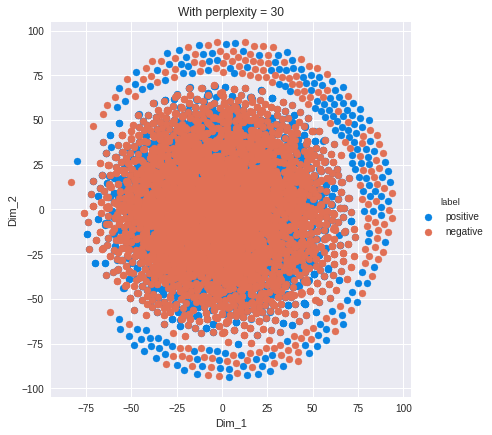

In [20]:
#Plotting
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

In [0]:
# TSNE
model2 = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 2000)


tsne_data2 = model2.fit_transform(X)


# creating a new data frame which help us in ploting the result data
tsne_data2 = np.vstack((tsne_data2.T, labels_10k)).T
tsne_df2 = pd.DataFrame(data=tsne_data2, columns=("Dim_1", "Dim_2", "label"))

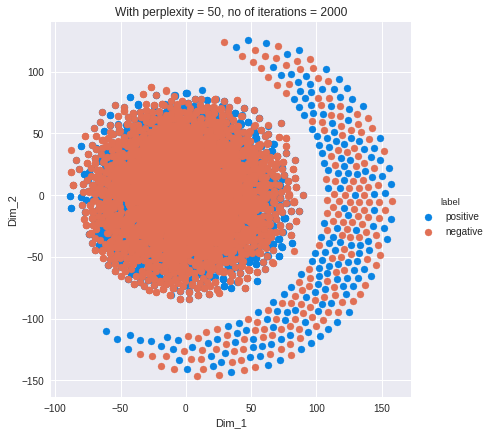

In [22]:
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df2, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, no of iterations = 2000')
plt.show()

# Visualizing 'TF-IDF'

In [0]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()


In [0]:
sc= StandardScaler(with_mean=False)
final_tf_idf = sc.fit_transform(final_tf_idf)

In [8]:
final_tf_idf.shape

(10000, 245526)

In [0]:
#T-SVD
svd = TruncatedSVD(n_components=1000)
X = svd.fit_transform(final_tf_idf)

In [0]:
from sklearn.manifold import TSNE

model3 = TSNE(n_components=2, random_state=0, perplexity = 30)
tsne_data3 = model3.fit_transform(X)

In [0]:
# creating a new data fram which help us in ploting the result data
tsne_data3 = np.vstack((tsne_data3.T, labels_10k)).T
tsne_df3 = pd.DataFrame(data=tsne_data3, columns=("Dim_1", "Dim_2", "label"))

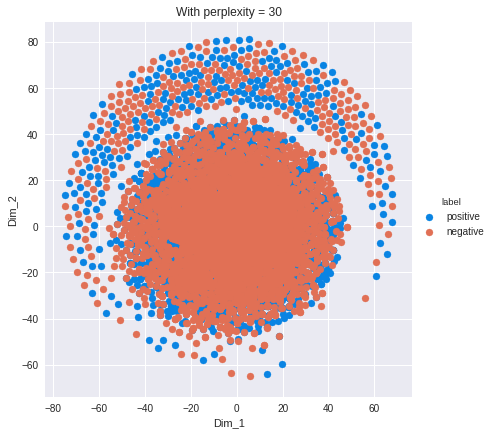

In [13]:
# Ploting the result of tsne
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df3, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

In [0]:
model4 = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 2000)
tsne_data4 = model4.fit_transform(X)

In [0]:
# creating a new data fram which help us in ploting the result data
tsne_data4 = np.vstack((tsne_data4.T, labels_10k)).T
tsne_df4 = pd.DataFrame(data=tsne_data4, columns=("Dim_1", "Dim_2", "label"))

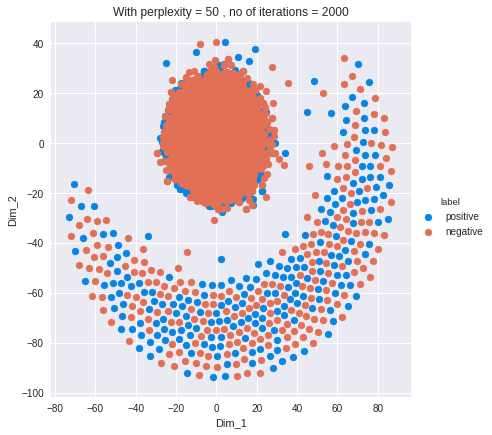

In [17]:
# Ploting the result of tsne
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df4, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 , no of iterations = 2000' )
plt.show()

**Training Word2Vec model**

In [0]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_data['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [27]:
print(final_data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

b'new favorit littl pricey way less youd pay coffe shop creami sweet chai tea sugar count low diabet spous sweet treat love reorder box time went first box fast care use largest cup set though unless want latt dilut'
*****************************************************************
['bnew', 'favorit', 'littl', 'pricey', 'way', 'less', 'youd', 'pay', 'coffe', 'shop', 'creami', 'sweet', 'chai', 'tea', 'sugar', 'count', 'low', 'diabet', 'spous', 'sweet', 'treat', 'love', 'reorder', 'box', 'time', 'went', 'first', 'box', 'fast', 'care', 'use', 'largest', 'cup', 'set', 'though', 'unless', 'want', 'latt', 'dilut']


In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [29]:
w2v_model.wv.most_similar('nice')

[('pleasant', 0.9217043519020081),
 ('fresh', 0.9125576019287109),
 ('aroma', 0.9033433198928833),
 ('perfect', 0.9001665115356445),
 ('amber', 0.8909069299697876),
 ('smooth', 0.8902672529220581),
 ('mild', 0.8886803984642029),
 ('odd', 0.8864750266075134),
 ('burnt', 0.8864576816558838),
 ('rich', 0.8859496116638184)]

# Visualizing Average Word2Vec

In [30]:
#AVG-W2V
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
50


In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
final_sent = sc.fit_transform(sent_vectors)



In [0]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 30)
tsne_data = model.fit_transform(final_sent)

In [0]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

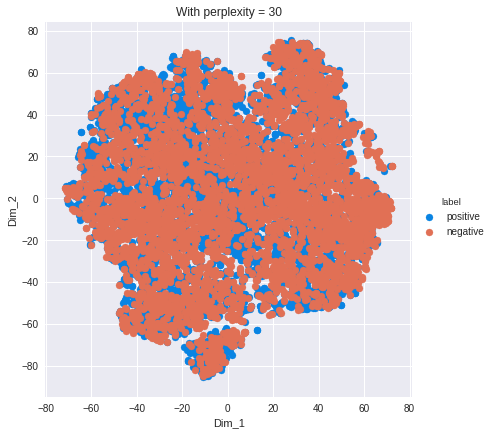

In [36]:
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

In [0]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 50,n_iter = 2000)
tsne_data = model.fit_transform(final_sent)

In [0]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

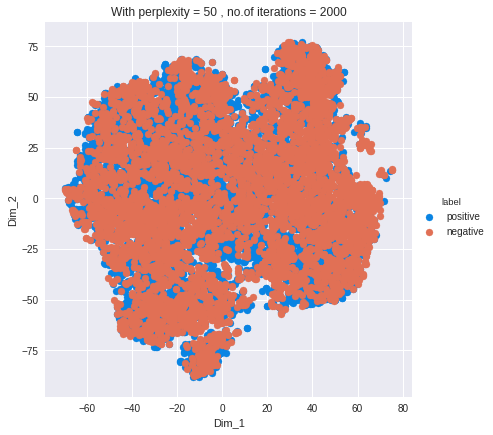

In [39]:
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 , no.of iterations = 2000')
plt.show()

# Visualizing Word2Vec-Tfidf

In [0]:
#TF-IDF

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final_data["CleanedText"].values)
tfidf_feat = tf_idf_vect.get_feature_names()
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
            
        except:
            pass

    sent_vec /= weight_sum
    print(np.isnan(np.sum(sent_vec)))

    tfidf_sent_vectors.append(sent_vec)
    row += 1
    



In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
final_tf_sent = sc.fit_transform(tfidf_sent_vectors)

In [0]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 30)
tsne_data = model.fit_transform(final_tf_sent)

In [0]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

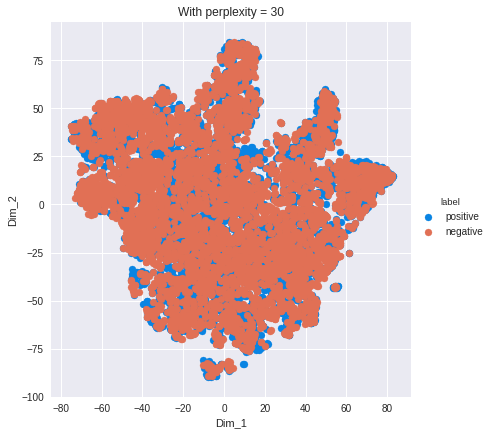

In [0]:
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30')
plt.show()

In [0]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 2000)
tsne_data = model.fit_transform(final_tf_sent)

In [0]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

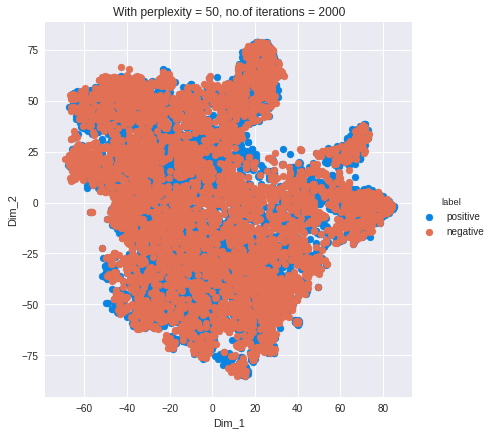

In [0]:
pal = dict(positive = "#0984e3", negative = "#e17055")
sns.FacetGrid(tsne_df, hue="label", size=6, palette = pal).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, no.of iterations = 2000')
plt.show()

# Conclusion

### Since number of data points are considerably low(10k out of 364k),the points are not that separated but still 'tf-idf'  and 'bag of words' vectorization techniques give the best results with perplexity of '50'.